In [34]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
with open('BMC_Wards.geojson') as json_data:
    mumbai_data = json.load(json_data)

In [3]:
mumbai_data

{'type': 'FeatureCollection',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features': [{'type': 'Feature',
   'properties': {'gid': 1, 'name': 'A'},
   'geometry': {'type': 'MultiPolygon',
    'coordinates': [[[[72.840253948166, 18.94880846402114],
       [72.84030270105343, 18.948804332423883],
       [72.8404167086157, 18.948830795037264],
       [72.84042772265047, 18.94883335134029],
       [72.84054906348473, 18.948861516161077],
       [72.84059164031676, 18.948871398026178],
       [72.84065147596793, 18.94888528730686],
       [72.84066545245484, 18.94888853116952],
       [72.84070090306439, 18.948894125295443],
       [72.84083049933672, 18.94891457291972],
       [72.84096878649683, 18.94893639160987],
       [72.84124619023915, 18.948980160362634],
       [72.84135278958591, 18.948992325083825],
       [72.84137756589088, 18.948995152716925],
       [72.84150367087838, 18.948991194539587],
       [72.84157947398036, 18.9489359918313

In [4]:
neighborhoods_data = mumbai_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'properties': {'gid': 1, 'name': 'A'},
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[72.840253948166, 18.94880846402114],
     [72.84030270105343, 18.948804332423883],
     [72.8404167086157, 18.948830795037264],
     [72.84042772265047, 18.94883335134029],
     [72.84054906348473, 18.948861516161077],
     [72.84059164031676, 18.948871398026178],
     [72.84065147596793, 18.94888528730686],
     [72.84066545245484, 18.94888853116952],
     [72.84070090306439, 18.948894125295443],
     [72.84083049933672, 18.94891457291972],
     [72.84096878649683, 18.94893639160987],
     [72.84124619023915, 18.948980160362634],
     [72.84135278958591, 18.948992325083825],
     [72.84137756589088, 18.948995152716925],
     [72.84150367087838, 18.948991194539587],
     [72.84157947398036, 18.948935991831398],
     [72.84163321971066, 18.948935957424613],
     [72.84163391270842, 18.948935956461963],
     [72.84168835144983, 18.948935920173373],
     [72.8417420772629

In [5]:
coordinates = np.array(neighborhoods_data[0]['geometry']['coordinates'])
coordinates.shape
coordinates.mean(axis=0)

array([[[72.84025395, 18.94880846],
        [72.8403027 , 18.94880433],
        [72.84041671, 18.9488308 ],
        ...,
        [72.84021008, 18.94881963],
        [72.84021665, 18.94881163],
        [72.84025395, 18.94880846]]])

In [6]:
lat, long = np.mean(np.mean(np.mean(neighborhoods_data[1]['geometry']['coordinates'], axis=0), axis=0), axis=0)
lat, long

(72.83971966684719, 18.95694072506568)

In [7]:
# define the dataframe columns
column_names = ['Ward', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [8]:
neighborhoods

,Ward,Latitude,Longitude


In [9]:
for data in neighborhoods_data:
    ward_name = data['properties']['name']
    coordinates = np.array(data['geometry']['coordinates'])
    means = coordinates
    if (len(means.shape)==2): # data for K ward needs a fix
        means=np.array(means[0][0])
    while (len(means.shape) >= 2):
        means=means.mean(axis=0)
    ward_lon, ward_lat = means
    neighborhoods = neighborhoods.append({'Ward': ward_name,
                                          'Latitude': ward_lat,
                                          'Longitude': ward_lon}, ignore_index=True)

In [10]:
neighborhoods

,Ward,Latitude,Longitude
0,A,18.920981,72.827472
1,B,18.956941,72.839720
2,C,18.951097,72.827200
3,D,18.955231,72.808287
4,E,18.973439,72.843214
5,F/S,18.998980,72.853965
6,G/S,19.004169,72.820140
7,F/N,19.031895,72.870740
8,G/N,19.030693,72.844038
9,N,19.086679,72.920185


In [13]:
neighborhoods['Ward'] = neighborhoods['Ward'].str.replace('/S', ' South')
neighborhoods['Ward'] = neighborhoods['Ward'].str.replace('/N', ' North')
neighborhoods['Ward'] = neighborhoods['Ward'].str.replace('/W', ' West')
neighborhoods['Ward'] = neighborhoods['Ward'].str.replace('/E', ' East')
neighborhoods['Ward'] = neighborhoods['Ward'].str.replace('/C', ' Central')
neighborhoods

,Ward,Latitude,Longitude
0,A,18.920981,72.827472
1,B,18.956941,72.839720
2,C,18.951097,72.827200
3,D,18.955231,72.808287
4,E,18.973439,72.843214
5,F South,18.998980,72.853965
6,G South,19.004169,72.820140
7,F North,19.031895,72.870740
8,G North,19.030693,72.844038
9,N,19.086679,72.920185


In [14]:
# for mumbai center takee the mean loaction of all wards so that map is centered properly
latitude = neighborhoods['Latitude'].mean()
longitude = neighborhoods['Longitude'].mean()
print('The geograpical coordinate of Mumbai City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mumbai City are 19.07505712563969, 72.85810027636394.


In [15]:
map_mumbai = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(neighborhoods['Latitude'], neighborhoods['Longitude'],neighborhoods['Ward']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mumbai)  
    
map_mumbai


In [16]:
CLIENT_ID = 'DWEXM50DMIASXE1ICCHVYPI04OUZVWWERCNWTLAXFKWFTLIP' # your Foursquare ID
CLIENT_SECRET = 'HWYPBBRK1N5R2XT3BCXDPKZQAXMYU4VSWUE23Q2LO4HASPZP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT=100

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        urljson = requests.get(url).json()
        print(urljson["response"])
        results = urljson["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Ward', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
mumbai_venues = getNearbyVenues(names=neighborhoods['Ward'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )



A
{'suggestedFilters': {'header': 'Tap to show:', 'filters': [{'name': 'Open now', 'key': 'openNow'}]}, 'headerLocation': 'Mumbai', 'headerFullLocation': 'Mumbai', 'headerLocationGranularity': 'city', 'totalResults': 33, 'suggestedBounds': {'ne': {'lat': 18.925481307166525, 'lng': 72.83221966743481}, 'sw': {'lat': 18.916481298166513, 'lng': 72.8227233446243}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b1145fff964a520937923e3', 'name': 'Theobroma', 'location': {'address': 'Shop 24, Cusrow Baug, Colaba Causeway', 'crossStreet': 'Shahid Bhagat Singh Road', 'lat': 18.91929830684632, 'lng': 72.82918453216553, 'labeledLatLngs': [{'label': 'display', 'lat': 18.91929830684632, 'lng': 72.82918453216553}], 'distance': 260, 'postalCode': '400005', 'cc': 'IN', 'neighborhood': 'Colaba', 'city': 'Mumbai', 'state': 'Ma

{'headerLocation': 'Mumbai', 'headerFullLocation': 'Mumbai', 'headerLocationGranularity': 'city', 'totalResults': 6, 'suggestedBounds': {'ne': {'lat': 18.961440729565687, 'lng': 72.84446885090743}, 'sw': {'lat': 18.952440720565676, 'lng': 72.83497048278694}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4da82ee86a2364c7a34db978', 'name': 'Le Mill', 'location': {'lat': 18.957378865718038, 'lng': 72.8407423537711, 'labeledLatLngs': [{'label': 'display', 'lat': 18.957378865718038, 'lng': 72.8407423537711}], 'distance': 118, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1f8941735', 'name': 'Furniture / Home Store', 'pluralName': 'Furniture / Home Stores', 'shortName': 'Furniture / Home', 'ic

{'headerLocation': 'Malabar Hill', 'headerFullLocation': 'Malabar Hill, Mumbai', 'headerLocationGranularity': 'neighborhood', 'totalResults': 16, 'suggestedBounds': {'ne': {'lat': 18.959731343562197, 'lng': 72.81303577048816}, 'sw': {'lat': 18.950731334562185, 'lng': 72.80353749969926}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4cd194c801eaf04d9122bf5d', 'name': 'Soam', 'location': {'address': '3 Sadguru Sadan, opp. Babulnath Temple, Girgaum Chowpatty,', 'lat': 18.957492031614574, 'lng': 72.80888354503129, 'labeledLatLngs': [{'label': 'display', 'lat': 18.957492031614574, 'lng': 72.80888354503129}], 'distance': 259, 'postalCode': '400007', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['3 Sadguru Sadan, opp. Babulnath Temple, Girgaum Chowpatty,', 'Mumbai 40

{'headerLocation': 'Mumbai', 'headerFullLocation': 'Mumbai', 'headerLocationGranularity': 'city', 'totalResults': 4, 'suggestedBounds': {'ne': {'lat': 18.977939086007094, 'lng': 72.84796371105988}, 'sw': {'lat': 18.968939077007082, 'lng': 72.83846440299412}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4e928eda55037de99d6d9696', 'name': 'Gupta ice cream', 'location': {'address': '103 A/B Mount To ad', 'crossStreet': 'Anjirwadi, Mazgaon', 'lat': 18.973559220847054, 'lng': 72.84022215304088, 'labeledLatLngs': [{'label': 'display', 'lat': 18.973559220847054, 'lng': 72.84022215304088}], 'distance': 315, 'postalCode': '400010', 'cc': 'IN', 'city': 'mumbai', 'state': 'maharshtra', 'country': 'India', 'formattedAddress': ['103 A/B Mount To ad (Anjirwadi, Mazgaon)', 'mumbai 400010', 'maharshtra', 'India']}, 'catego

{'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."}, 'headerLocation': 'Mumbai', 'headerFullLocation': 'Mumbai', 'headerLocationGranularity': 'city', 'totalResults': 1, 'suggestedBounds': {'ne': {'lat': 19.03639489755815, 'lng': 72.87549179412747}, 'sw': {'lat': 19.02739488855814, 'lng': 72.86598914787294}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4fcf65bee4b0dd1e7cee0b1d', 'name': "Domino's Pizza", 'location': {'address': 'GROUND FLOOR,SHOP NO-A14 & A-15A-2, WING D & E,C.S.NO 85-93SALT PAN DIVISION, KALPAK ESTATE, S.M. ROADANTOP HILL,WADALA,MUMBAI', 'lat': 19.03, 'lng': 72.867, 'labeledLatLngs': [{'label': 'display', 'lat': 19.03, 'lng': 72.867}], 'distance': 446, 'postalCode': '400037', 'cc': 'IN', 'city': 'Mumbai',

{'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."}, 'headerLocation': 'Vikhroli West', 'headerFullLocation': 'Vikhroli West, Mumbai', 'headerLocationGranularity': 'neighborhood', 'totalResults': 3, 'suggestedBounds': {'ne': {'lat': 19.091179324747113, 'lng': 72.92493770763564}, 'sw': {'lat': 19.0821793157471, 'lng': 72.91543192173565}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4bf0c01325afb713c1e94a6f', 'name': 'Ghatkopar Bus Depot', 'location': {'address': 'Ghatkopar East', 'crossStreet': 'off Eastern Express Highway', 'lat': 19.088125592929597, 'lng': 72.91815031252219, 'labeledLatLngs': [{'label': 'display', 'lat': 19.088125592929597, 'lng': 72.91815031252219}], 'distance': 267, 'cc': 'IN', 'city': 'Mumbai', 'state

{'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."}, 'headerLocation': 'Mumbai', 'headerFullLocation': 'Mumbai', 'headerLocationGranularity': 'city', 'totalResults': 0, 'suggestedBounds': {'ne': {'lat': 19.138089688223296, 'lng': 72.92666678258523}, 'sw': {'lat': 19.129089679223284, 'lng': 72.91715829973505}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': []}]}
T
{'suggestedFilters': {'header': 'Tap to show:', 'filters': [{'name': 'Open now', 'key': 'openNow'}]}, 'headerLocation': 'Mulund', 'headerFullLocation': 'Mulund, Mumbai', 'headerLocationGranularity': 'neighborhood', 'totalResults': 16, 'suggestedBounds': {'ne': {'lat': 19.172011317667515, 'lng': 72.94230941298576}, 'sw': {'lat': 19.163011308667503, 'lng': 72.93279897500173}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popul

{'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."}, 'headerLocation': 'Current map view', 'headerFullLocation': 'Current map view', 'headerLocationGranularity': 'unknown', 'totalResults': 0, 'suggestedBounds': {'ne': {'lat': 19.13809402782975, 'lng': 72.78665153670676}, 'sw': {'lat': 19.12909401882974, 'lng': 72.77714305360672}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': []}]}
R North
{'headerLocation': 'Dahisar East', 'headerFullLocation': 'Dahisar East, Mumbai', 'headerLocationGranularity': 'neighborhood', 'totalResults': 8, 'suggestedBounds': {'ne': {'lat': 19.259783463146007, 'lng': 72.87110486631123}, 'sw': {'lat': 19.250783454145996, 'lng': 72.8615893502017}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}

{'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."}, 'headerLocation': 'Chembur', 'headerFullLocation': 'Chembur, Mumbai', 'headerLocationGranularity': 'neighborhood', 'totalResults': 1, 'suggestedBounds': {'ne': {'lat': 19.042348581024708, 'lng': 72.89409142435834}, 'sw': {'lat': 19.033348572024696, 'lng': 72.88458843742485}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4fb49372e4b0719cde06eec8', 'name': 'Alibaug', 'location': {'lat': 19.037905843648304, 'lng': 72.89371051724746, 'labeledLatLngs': [{'label': 'display', 'lat': 19.037905843648304, 'lng': 72.89371051724746}], 'distance': 459, 'cc': 'IN', 'country': 'India', 'formattedAddress': ['India']}, 'categories': [{'id': '4bf58dd8d48988d1e2941735', 'name': 'Beach', 'p

{'headerLocation': 'Goregaon', 'headerFullLocation': 'Goregaon, Mumbai', 'headerLocationGranularity': 'neighborhood', 'totalResults': 5, 'suggestedBounds': {'ne': {'lat': 19.161993993121705, 'lng': 72.86314787574553}, 'sw': {'lat': 19.152993984121693, 'lng': 72.85363801555842}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4cb35bedc5e6a1cd592fecf6', 'name': "McDonald's", 'location': {'address': 'Western Express Hwy.', 'lat': 19.154510917747306, 'lng': 72.85646222090531, 'labeledLatLngs': [{'label': 'display', 'lat': 19.154510917747306, 'lng': 72.85646222090531}], 'distance': 389, 'postalCode': '400065', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Western Express Hwy.', 'Mumbai 400065', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d16e94173

{'headerLocation': 'Kandivali West', 'headerFullLocation': 'Kandivali West, Mumbai', 'headerLocationGranularity': 'neighborhood', 'totalResults': 5, 'suggestedBounds': {'ne': {'lat': 19.204133412067137, 'lng': 72.86092208440094}, 'sw': {'lat': 19.195133403067125, 'lng': 72.85140979118692}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4e30f62818380c94aca64f93', 'name': 'V K Snacks', 'location': {'address': 'Shop No - 4, Sai Arman Building', 'crossStreet': 'Ashok Chakravarti Road. Ashok Nagar', 'lat': 19.19888497325031, 'lng': 72.85692212956369, 'labeledLatLngs': [{'label': 'display', 'lat': 19.19888497325031, 'lng': 72.85692212956369}], 'distance': 115, 'postalCode': '400101', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Shop No - 4, Sai Arman Building (Asho

{'suggestedFilters': {'header': 'Tap to show:', 'filters': [{'name': 'Open now', 'key': 'openNow'}]}, 'headerLocation': 'Mumbai', 'headerFullLocation': 'Mumbai', 'headerLocationGranularity': 'city', 'totalResults': 49, 'suggestedBounds': {'ne': {'lat': 19.092301332792257, 'lng': 72.89017162796564}, 'sw': {'lat': 19.083301323792245, 'lng': 72.88066577765188}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51d2a531454ad6055f94cdce', 'name': 'Hamleys', 'location': {'address': 'Phoenix Market City Kurla', 'crossStreet': 'LBS Marg,Near Kamani Junction, Kurla West', 'lat': 19.08665464005278, 'lng': 72.88978308735972, 'labeledLatLngs': [{'label': 'display', 'lat': 19.08665464005278, 'lng': 72.88978308735972}], 'distance': 476, 'postalCode': '400070', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': '

In [21]:
print(mumbai_venues.shape)
mumbai_venues.head()

(328, 7)


,Ward,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,A,18.920981,72.827472,Theobroma,18.919298,72.829185,Dessert Shop
1,A,18.920981,72.827472,New Martin,18.918624,72.829512,Indian Restaurant
2,A,18.920981,72.827472,Mad Over Donuts,18.919209,72.829427,Donut Shop
3,A,18.920981,72.827472,Café Basilico,18.918609,72.830484,Diner
4,A,18.920981,72.827472,Piccadilly,18.921425,72.830936,Falafel Restaurant


In [22]:
mumbai_venues.groupby('Ward').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Ward,,,,,,
A,33,33,33,33,33,33
B,6,6,6,6,6,6
C,8,8,8,8,8,8
D,16,16,16,16,16,16
E,4,4,4,4,4,4
F North,1,1,1,1,1,1
F South,4,4,4,4,4,4
G North,22,22,22,22,22,22
G South,5,5,5,5,5,5


In [23]:
print('There are {} uniques categories.'.format(len(mumbai_venues['Venue Category'].unique())))

There are 94 uniques categories.


In [24]:
# one hot encoding
mumbai_onehot = pd.get_dummies(mumbai_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
mumbai_onehot['Ward'] = mumbai_venues['Ward'] 

# move neighborhood column to the first column
fixed_columns = [mumbai_onehot.columns[-1]] + list(mumbai_onehot.columns[:-1])
mumbai_onehot = mumbai_onehot[fixed_columns]

mumbai_onehot.head()

,Ward,American Restaurant,Arcade,Art Gallery,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Bed & Breakfast,Beer Garden,Bistro,Bookstore,Bowling Alley,Burrito Place,Bus Station,Café,Chaat Place,Chinese Restaurant,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,French Restaurant,Furniture / Home Store,Gastropub,German Restaurant,Goan Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Juice Bar,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Nightclub,Park,Pizza Place,Playground,Pub,Restaurant,Salad Place,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Spa,Spanish Restaurant,Sports Bar,Stadium,Tennis Court,Thai Restaurant,Theater,Theme Park,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
mumbai_onehot.shape

(328, 95)

In [26]:
mumbai_grouped = mumbai_onehot.groupby('Ward').mean().reset_index()
mumbai_grouped

,Ward,American Restaurant,Arcade,Art Gallery,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Bed & Breakfast,Beer Garden,Bistro,Bookstore,Bowling Alley,Burrito Place,Bus Station,Café,Chaat Place,Chinese Restaurant,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,French Restaurant,Furniture / Home Store,Gastropub,German Restaurant,Goan Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Juice Bar,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Nightclub,Park,Pizza Place,Playground,Pub,Restaurant,Salad Place,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Spa,Spanish Restaurant,Sports Bar,Stadium,Tennis Court,Thai Restaurant,Theater,Theme Park,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,A,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.121212,0.030303,0.030303,0.000000,0.060606,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.030303,0.000000,0.090909,0.030303,0.000000,0.030303,0.000000,0.000000,0.000000,0.030303,0.000,0.0000,0.000000,0.000000,0.030303,0.0000,0.030303,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.030303,0.060606,0.000000,0.000000,0.151515,0.000000,0.030303,0.000000,0.030303,0.030303,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000,0.030303,0.030303,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.030303,0.030303,0.000000,0.0000,0.000000,0.030303,0.000000,0.000000,0.000000
1,B,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000,0.0000,0.000000,0.000000,0.166667,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
2,C,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.125,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.125000,0.000000,0.0000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
3,D,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.062500,0.125000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [27]:
mumbai_grouped.shape

(22, 95)

In [28]:
num_top_venues = 5

for hood in mumbai_grouped['Ward']:
    print("----Ward "+hood+"----")
    temp = mumbai_grouped[mumbai_grouped['Ward'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ward A----
               venue  freq
0  Indian Restaurant  0.15
1               Café  0.12
2              Diner  0.09
3        Coffee Shop  0.06
4              Hotel  0.06


----Ward B----
                    venue  freq
0         Harbor / Marina  0.17
1  Furniture / Home Store  0.17
2             Flea Market  0.17
3       Indian Restaurant  0.17
4       Convenience Store  0.17


----Ward C----
                  venue  freq
0     Indian Restaurant  0.38
1  Fast Food Restaurant  0.12
2             Multiplex  0.12
3    Chinese Restaurant  0.12
4        Ice Cream Shop  0.12


----Ward D----
               venue  freq
0  Indian Restaurant  0.38
1        Coffee Shop  0.12
2         Restaurant  0.06
3     Ice Cream Shop  0.06
4     Clothing Store  0.06


----Ward E----
                 venue  freq
0         Dessert Shop  0.25
1       Ice Cream Shop  0.25
2    Indian Restaurant  0.25
3                 Café  0.25
4  American Restaurant  0.00


----Ward F North----
                 venue  

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Ward']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Ward'] = mumbai_grouped['Ward']

for ind in np.arange(mumbai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mumbai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A,Indian Restaurant,Café,Diner,Coffee Shop,Hotel,Flea Market,Mediterranean Restaurant,Juice Bar,Chinese Restaurant,Chaat Place
1,B,Convenience Store,Indian Restaurant,Harbor / Marina,Flea Market,Hotel,Furniture / Home Store,Bagel Shop,BBQ Joint,Department Store,Dessert Shop
2,C,Indian Restaurant,Multiplex,Chinese Restaurant,Food,Fast Food Restaurant,Ice Cream Shop,Donut Shop,Cupcake Shop,Dance Studio,Deli / Bodega
3,D,Indian Restaurant,Coffee Shop,Café,Food & Drink Shop,Ice Cream Shop,Park,Clothing Store,Restaurant,Gastropub,Theater
4,E,Dessert Shop,Café,Ice Cream Shop,Indian Restaurant,Women's Store,Falafel Restaurant,Dance Studio,Deli / Bodega,Department Store,Dim Sum Restaurant


In [32]:
mumbai_grouped_clustering = mumbai_grouped.drop('Ward', 1)
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    kmeans = KMeans(n_clusters=n, random_state=0).fit(mumbai_grouped_clustering)
    mean_acc[n-1] = kmeans.inertia_   #kmeans.score(mumbai_grouped_clustering)

 
mean_acc

array([4.49045608, 3.49575813, 2.52767884, 2.04748494, 1.75338234,
       1.55062199, 1.35142289, 1.15366915, 1.0188254 ])

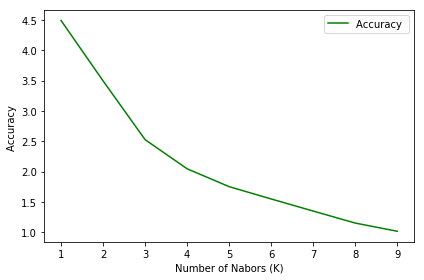

In [35]:
plt.plot(range(1,Ks),mean_acc,'g')
#plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [36]:
# set number of clusters to 5 based on elbow
kclusters = 5

mumbai_grouped_clustering = mumbai_grouped.drop('Ward', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mumbai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 1, 1, 1, 3, 0, 1, 4, 1])

In [37]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


In [39]:
#print(mumbai_merged['Cluster Labels'], neighborhoods_venues_sorted['Ward'], neighborhoods['Ward'])
mumbai_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
mumbai_merged = mumbai_merged.join(neighborhoods_venues_sorted.set_index('Ward'), on='Ward')
mumbai_merged.dropna(axis=0, inplace=True)
#print(mumbai_merged['Cluster Labels'])
mumbai_merged['Cluster Labels'] = mumbai_merged['Cluster Labels'].astype(int)
mumbai_merged.head() # check the last columns!

,Ward,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A,18.920981,72.827472,1,Indian Restaurant,Café,Diner,Coffee Shop,Hotel,Flea Market,Mediterranean Restaurant,Juice Bar,Chinese Restaurant,Chaat Place
1,B,18.956941,72.839720,0,Convenience Store,Indian Restaurant,Harbor / Marina,Flea Market,Hotel,Furniture / Home Store,Bagel Shop,BBQ Joint,Department Store,Dessert Shop
2,C,18.951097,72.827200,1,Indian Restaurant,Multiplex,Chinese Restaurant,Food,Fast Food Restaurant,Ice Cream Shop,Donut Shop,Cupcake Shop,Dance Studio,Deli / Bodega
3,D,18.955231,72.808287,1,Indian Restaurant,Coffee Shop,Café,Food & Drink Shop,Ice Cream Shop,Park,Clothing Store,Restaurant,Gastropub,Theater
4,E,18.973439,72.843214,1,Dessert Shop,Café,Ice Cream Shop,Indian Restaurant,Women's Store,Falafel Restaurant,Dance Studio,Deli / Bodega,Department Store,Dim Sum Restaurant


In [40]:
mumbai_merged.shape

(22, 14)

In [41]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mumbai_merged['Latitude'], mumbai_merged['Longitude'], mumbai_merged['Ward'], mumbai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [42]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 0, mumbai_merged.columns[[0] + list(range(4, mumbai_merged.shape[1]))]]

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,B,Convenience Store,Indian Restaurant,Harbor / Marina,Flea Market,Hotel,Furniture / Home Store,Bagel Shop,BBQ Joint,Department Store,Dessert Shop
5,F South,Train Station,Harbor / Marina,Flea Market,Bus Station,Women's Store,Event Space,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store


In [43]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 1, mumbai_merged.columns[[0] + list(range(4, mumbai_merged.shape[1]))]]

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A,Indian Restaurant,Café,Diner,Coffee Shop,Hotel,Flea Market,Mediterranean Restaurant,Juice Bar,Chinese Restaurant,Chaat Place
2,C,Indian Restaurant,Multiplex,Chinese Restaurant,Food,Fast Food Restaurant,Ice Cream Shop,Donut Shop,Cupcake Shop,Dance Studio,Deli / Bodega
3,D,Indian Restaurant,Coffee Shop,Café,Food & Drink Shop,Ice Cream Shop,Park,Clothing Store,Restaurant,Gastropub,Theater
4,E,Dessert Shop,Café,Ice Cream Shop,Indian Restaurant,Women's Store,Falafel Restaurant,Dance Studio,Deli / Bodega,Department Store,Dim Sum Restaurant
8,G North,Indian Restaurant,Movie Theater,Chinese Restaurant,Goan Restaurant,Sandwich Place,Vegetarian / Vegan Restaurant,Fish Market,Fast Food Restaurant,Ice Cream Shop,Department Store
10,R Central,Restaurant,Café,Indian Restaurant,Arcade,Multiplex,Chinese Restaurant,Pub,Fast Food Restaurant,Bus Station,Women's Store
12,T,Pizza Place,Fast Food Restaurant,Café,Indian Restaurant,Shopping Mall,Food Court,Multiplex,Gym,Coffee Shop,Clothing Store
14,R North,Diner,Indian Restaurant,Juice Bar,Food Court,Playground,Chinese Restaurant,Bakery,Dance Studio,Deli / Bodega,Department Store
15,M East,Convenience Store,Grocery Store,Coffee Shop,Café,Indian Restaurant,Event Space,Dance Studio,Deli / Bodega,Department Store,Dessert Shop
17,H East,Indian Restaurant,Food & Drink Shop,Bakery,Ice Cream Shop,Falafel Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant


In [44]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 2, mumbai_merged.columns[[0] + list(range(4, mumbai_merged.shape[1]))]]

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,M West,Beach,Women's Store,Falafel Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner


In [45]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 3, mumbai_merged.columns[[0] + list(range(4, mumbai_merged.shape[1]))]]

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,F North,Pizza Place,Event Space,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner


In [46]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 4, mumbai_merged.columns[[0] + list(range(4, mumbai_merged.shape[1]))]]

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,G South,Lounge,Arcade,Art Gallery,Thai Restaurant,Women's Store,Falafel Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop
9,N,Bus Station,Bank,Lounge,Women's Store,Event Space,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant


In [47]:
mumbai_venues

,Ward,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,A,18.920981,72.827472,Theobroma,18.919298,72.829185,Dessert Shop
1,A,18.920981,72.827472,New Martin,18.918624,72.829512,Indian Restaurant
2,A,18.920981,72.827472,Mad Over Donuts,18.919209,72.829427,Donut Shop
3,A,18.920981,72.827472,Café Basilico,18.918609,72.830484,Diner
4,A,18.920981,72.827472,Piccadilly,18.921425,72.830936,Falafel Restaurant
5,A,18.920981,72.827472,Colaba Market,18.920928,72.830959,Flea Market
6,A,18.920981,72.827472,The Cooperage Football Stadium,18.924913,72.828293,Stadium
7,A,18.920981,72.827472,Leopold Café,18.922828,72.831709,Café
8,A,18.920981,72.827472,Café Churchill,18.920167,72.830136,Café
9,A,18.920981,72.827472,Gable's,18.918856,72.828062,Restaurant


In [138]:
mumbai_analysis_full = mumbai_venues.merge(mumbai_merged, on='Ward')
mumbai_analysis_full.head()

,Ward,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A,18.920981,72.827472,Theobroma,18.919298,72.829185,Dessert Shop,18.920981,72.827472,0,Indian Restaurant,Café,Diner,Coffee Shop,Hotel,Flea Market,Mediterranean Restaurant,Juice Bar,Chinese Restaurant,Chaat Place
1,A,18.920981,72.827472,New Martin,18.918624,72.829512,Indian Restaurant,18.920981,72.827472,0,Indian Restaurant,Café,Diner,Coffee Shop,Hotel,Flea Market,Mediterranean Restaurant,Juice Bar,Chinese Restaurant,Chaat Place
2,A,18.920981,72.827472,Mad Over Donuts,18.919209,72.829427,Donut Shop,18.920981,72.827472,0,Indian Restaurant,Café,Diner,Coffee Shop,Hotel,Flea Market,Mediterranean Restaurant,Juice Bar,Chinese Restaurant,Chaat Place
3,A,18.920981,72.827472,Café Basilico,18.918609,72.830484,Diner,18.920981,72.827472,0,Indian Restaurant,Café,Diner,Coffee Shop,Hotel,Flea Market,Mediterranean Restaurant,Juice Bar,Chinese Restaurant,Chaat Place
4,A,18.920981,72.827472,Piccadilly,18.921425,72.830936,Falafel Restaurant,18.920981,72.827472,0,Indian Restaurant,Café,Diner,Coffee Shop,Hotel,Flea Market,Mediterranean Restaurant,Juice Bar,Chinese Restaurant,Chaat Place


In [139]:
mumbai_analysis = mumbai_analysis_full[['Ward', 'Cluster Labels', 'Venue Category']]
mumbai_analysis.head()

,Ward,Cluster Labels,Venue Category
0,A,0,Dessert Shop
1,A,0,Indian Restaurant
2,A,0,Donut Shop
3,A,0,Diner
4,A,0,Falafel Restaurant


In [146]:
#mumbai_cluster_counts = mumbai_analysis.groupby('Cluster Labels')['Venue Category'].value_counts().unstack().fillna(0)
mumbai_cluster_counts = mumbai_analysis.groupby('Cluster Labels')['Venue Category'].value_counts().to_frame(name='Count').reset_index()
#mumbai_cluster_counts.columns = ['Cluster Labels', 'Venue Category', 'Count']
mumbai_cluster_counts

,Cluster Labels,Venue Category,Count
0,0,Indian Restaurant,29
1,0,Café,20
2,0,Coffee Shop,12
3,0,Chinese Restaurant,10
4,0,Fast Food Restaurant,8
5,0,Clothing Store,7
6,0,Pub,7
7,0,Bar,6
8,0,Dessert Shop,6
9,0,Restaurant,6


In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

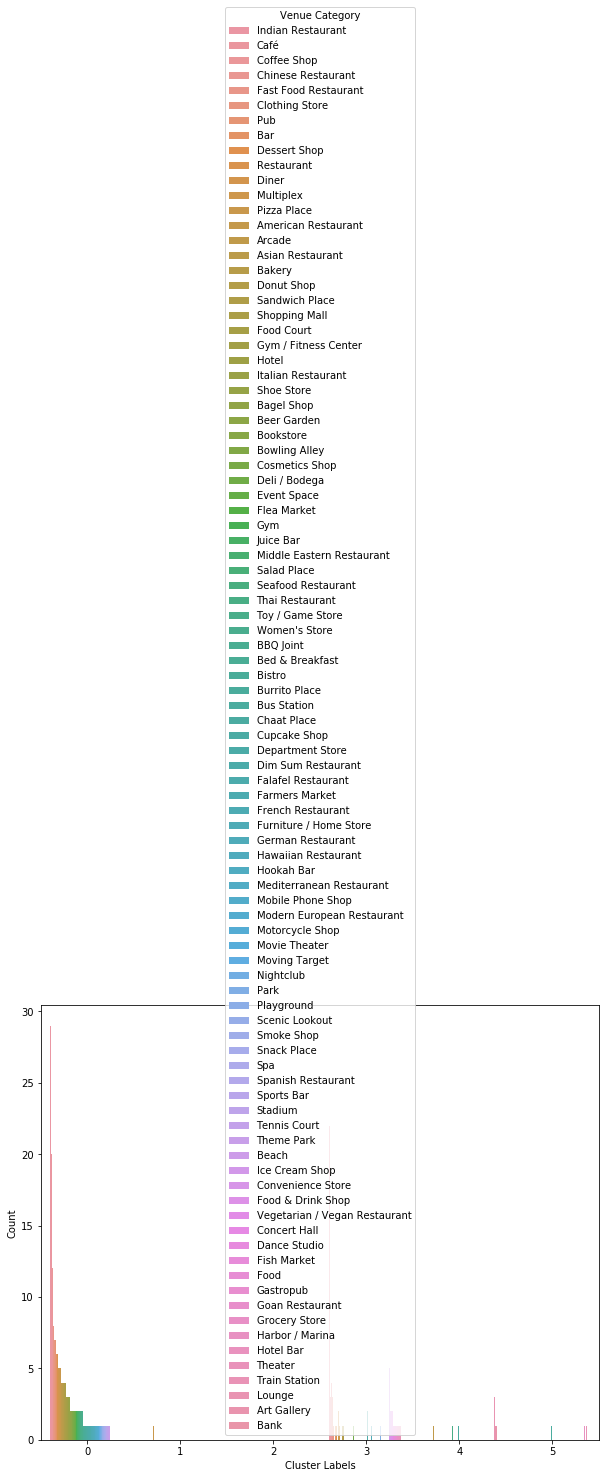

In [151]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,8))
ax = sns.barplot(x='Cluster Labels', y='Count', hue='Venue Category', data=mumbai_cluster_counts, ax=ax)
plt.show()

In [69]:
mumbai_sub = mumbai_merged[mumbai_merged['Cluster Labels'] == 1].copy()
mumbai_sub

,Ward,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A,18.920981,72.827472,1,Indian Restaurant,Café,Diner,Coffee Shop,Hotel,Flea Market,Mediterranean Restaurant,Juice Bar,Chinese Restaurant,Chaat Place
2,C,18.951097,72.827200,1,Indian Restaurant,Multiplex,Chinese Restaurant,Food,Fast Food Restaurant,Ice Cream Shop,Donut Shop,Cupcake Shop,Dance Studio,Deli / Bodega
3,D,18.955231,72.808287,1,Indian Restaurant,Coffee Shop,Café,Food & Drink Shop,Ice Cream Shop,Park,Clothing Store,Restaurant,Gastropub,Theater
4,E,18.973439,72.843214,1,Dessert Shop,Café,Ice Cream Shop,Indian Restaurant,Women's Store,Falafel Restaurant,Dance Studio,Deli / Bodega,Department Store,Dim Sum Restaurant
8,G North,19.030693,72.844038,1,Indian Restaurant,Movie Theater,Chinese Restaurant,Goan Restaurant,Sandwich Place,Vegetarian / Vegan Restaurant,Fish Market,Fast Food Restaurant,Ice Cream Shop,Department Store
10,R Central,19.233691,72.829735,1,Restaurant,Café,Indian Restaurant,Arcade,Multiplex,Chinese Restaurant,Pub,Fast Food Restaurant,Bus Station,Women's Store
12,T,19.167511,72.937554,1,Pizza Place,Fast Food Restaurant,Café,Indian Restaurant,Shopping Mall,Food Court,Multiplex,Gym,Coffee Shop,Clothing Store
14,R North,19.255283,72.866347,1,Diner,Indian Restaurant,Juice Bar,Food Court,Playground,Chinese Restaurant,Bakery,Dance Studio,Deli / Bodega,Department Store
15,M East,19.044800,72.921606,1,Convenience Store,Grocery Store,Coffee Shop,Café,Indian Restaurant,Event Space,Dance Studio,Deli / Bodega,Department Store,Dessert Shop
17,H East,19.077906,72.859472,1,Indian Restaurant,Food & Drink Shop,Bakery,Ice Cream Shop,Falafel Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant


In [70]:
mumbai_sub.drop('Cluster Labels', axis=1, inplace=True)
#mumbai_sub.drop(['Ward', 'Latitude', 'Longitude'], axis=1)
mumbai_sub

,Ward,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A,18.920981,72.827472,Indian Restaurant,Café,Diner,Coffee Shop,Hotel,Flea Market,Mediterranean Restaurant,Juice Bar,Chinese Restaurant,Chaat Place
2,C,18.951097,72.827200,Indian Restaurant,Multiplex,Chinese Restaurant,Food,Fast Food Restaurant,Ice Cream Shop,Donut Shop,Cupcake Shop,Dance Studio,Deli / Bodega
3,D,18.955231,72.808287,Indian Restaurant,Coffee Shop,Café,Food & Drink Shop,Ice Cream Shop,Park,Clothing Store,Restaurant,Gastropub,Theater
4,E,18.973439,72.843214,Dessert Shop,Café,Ice Cream Shop,Indian Restaurant,Women's Store,Falafel Restaurant,Dance Studio,Deli / Bodega,Department Store,Dim Sum Restaurant
8,G North,19.030693,72.844038,Indian Restaurant,Movie Theater,Chinese Restaurant,Goan Restaurant,Sandwich Place,Vegetarian / Vegan Restaurant,Fish Market,Fast Food Restaurant,Ice Cream Shop,Department Store
10,R Central,19.233691,72.829735,Restaurant,Café,Indian Restaurant,Arcade,Multiplex,Chinese Restaurant,Pub,Fast Food Restaurant,Bus Station,Women's Store
12,T,19.167511,72.937554,Pizza Place,Fast Food Restaurant,Café,Indian Restaurant,Shopping Mall,Food Court,Multiplex,Gym,Coffee Shop,Clothing Store
14,R North,19.255283,72.866347,Diner,Indian Restaurant,Juice Bar,Food Court,Playground,Chinese Restaurant,Bakery,Dance Studio,Deli / Bodega,Department Store
15,M East,19.044800,72.921606,Convenience Store,Grocery Store,Coffee Shop,Café,Indian Restaurant,Event Space,Dance Studio,Deli / Bodega,Department Store,Dessert Shop
17,H East,19.077906,72.859472,Indian Restaurant,Food & Drink Shop,Bakery,Ice Cream Shop,Falafel Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant


In [57]:
# add clustering labels
mumbai_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
mumbai_grouped

,Cluster Labels,Ward,American Restaurant,Arcade,Art Gallery,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Bed & Breakfast,Beer Garden,Bistro,Bookstore,Bowling Alley,Burrito Place,Bus Station,Café,Chaat Place,Chinese Restaurant,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,French Restaurant,Furniture / Home Store,Gastropub,German Restaurant,Goan Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Juice Bar,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Nightclub,Park,Pizza Place,Playground,Pub,Restaurant,Salad Place,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Spa,Spanish Restaurant,Sports Bar,Stadium,Tennis Court,Thai Restaurant,Theater,Theme Park,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,1,A,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.121212,0.030303,0.030303,0.000000,0.060606,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.030303,0.000000,0.090909,0.030303,0.000000,0.030303,0.000000,0.000000,0.000000,0.030303,0.000,0.0000,0.000000,0.000000,0.030303,0.0000,0.030303,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.030303,0.060606,0.000000,0.000000,0.151515,0.000000,0.030303,0.000000,0.030303,0.030303,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000,0.030303,0.030303,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.030303,0.030303,0.000000,0.0000,0.000000,0.030303,0.000000,0.000000,0.000000
1,0,B,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000,0.0000,0.000000,0.000000,0.166667,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,C,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.125,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.125000,0.000000,0.0000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1,D,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.062500,0.125000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [71]:
mumbai_sub_grouped = mumbai_grouped[mumbai_grouped['Cluster Labels'] == 1].copy()
mumbai_sub_grouped

,Cluster Labels,Ward,American Restaurant,Arcade,Art Gallery,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Bed & Breakfast,Beer Garden,Bistro,Bookstore,Bowling Alley,Burrito Place,Bus Station,Café,Chaat Place,Chinese Restaurant,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,French Restaurant,Furniture / Home Store,Gastropub,German Restaurant,Goan Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Juice Bar,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Nightclub,Park,Pizza Place,Playground,Pub,Restaurant,Salad Place,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Spa,Spanish Restaurant,Sports Bar,Stadium,Tennis Court,Thai Restaurant,Theater,Theme Park,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,1,A,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.121212,0.030303,0.030303,0.000000,0.060606,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.030303,0.000000,0.090909,0.030303,0.000000,0.030303,0.000000,0.000000,0.000000,0.030303,0.000,0.0000,0.000000,0.000000,0.030303,0.0000,0.030303,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.030303,0.060606,0.000000,0.000000,0.151515,0.000000,0.030303,0.0,0.030303,0.030303,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000,0.030303,0.030303,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.030303,0.030303,0.000000,0.0000,0.000000,0.030303,0.000000,0.000000,0.000000
2,1,C,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.125,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.125000,0.375000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.125000,0.000000,0.0000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1,D,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.062500,0.125000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0625,0.000000,0.000000,0.000000,0.0625,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.062500,0.375000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0625,0.000000,0.000,0.000000,0.062500,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000
4,1,E,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0000,0.000000,0.000

In [73]:
mumbai_sub_grouped.drop('Cluster Labels', axis=1, inplace=True)
mumbai_sub_grouped.head()

,Ward,American Restaurant,Arcade,Art Gallery,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Bed & Breakfast,Beer Garden,Bistro,Bookstore,Bowling Alley,Burrito Place,Bus Station,Café,Chaat Place,Chinese Restaurant,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,French Restaurant,Furniture / Home Store,Gastropub,German Restaurant,Goan Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Juice Bar,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Nightclub,Park,Pizza Place,Playground,Pub,Restaurant,Salad Place,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Spa,Spanish Restaurant,Sports Bar,Stadium,Tennis Court,Thai Restaurant,Theater,Theme Park,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.121212,0.030303,0.030303,0.0000,0.060606,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.030303,0.0,0.090909,0.030303,0.0,0.030303,0.0,0.000000,0.000000,0.030303,0.000,0.0000,0.0,0.0,0.030303,0.0000,0.030303,0.000000,0.0,0.0,0.0,0.0,0.0,0.030303,0.060606,0.0,0.000000,0.151515,0.0,0.030303,0.0,0.030303,0.030303,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0000,0.0,0.0,0.030303,0.030303,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030303,0.030303,0.0,0.0000,0.0,0.030303,0.000000,0.000000,0.0
2,C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.125000,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.125000,0.000000,0.000000,0.125,0.0000,0.0,0.0,0.000000,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.125000,0.375000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.125,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0000,0.0,0.000000,0.000000,0.000000,0.0
3,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,0.000000,0.000000,0.0625,0.125000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.0625,0.0,0.0,0.000000,0.0625,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.062500,0.375000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0625,0.0,0.0,0.000000,0.062500,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0625,0.0,0.000000,0.000000,0.000000,0.0
4,E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.250000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.0000,0.0,0.0,0.000000,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.250000,0.250000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0000,0.0,0.000000,0.000000,0.000000,0.0
7,G North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.090909,0.0000,0.045455,0.045455,0.0,0.0,0.0,0.0,0.045455,0.045455,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.045455,0.045455,0.000000,0.000,0.0000,0.0,0.0,0.000000,0.0000,0.000000,0.045455,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.045455,0.227273,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.090909,0.0,0.000,0.0,0.0000,

In [74]:
mumbai_sub_grouped_clustering = mumbai_sub_grouped.drop('Ward', 1)
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    kmeans = KMeans(n_clusters=n, random_state=0).fit(mumbai_sub_grouped_clustering)
    mean_acc[n-1] = kmeans.inertia_   #kmeans.score(mumbai_grouped_clustering)

 
mean_acc

array([1.45504901, 1.215173  , 1.03757668, 0.86284071, 0.72520948,
       0.57772644, 0.45590442, 0.3581258 , 0.26874929])

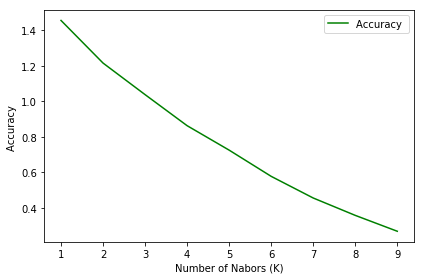

In [75]:
plt.plot(range(1,Ks),mean_acc,'g')
#plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [76]:
# set number of clusters to 5 based on elbow
kclusters = 5

mumbai_sub_grouped_clustering = mumbai_sub_grouped.drop('Ward', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mumbai_sub_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 3, 3, 0, 3, 2, 0, 3, 0, 0])

In [77]:
# add clustering labels
mumbai_sub.insert(0, 'Cluster Labels', kmeans.labels_)
mumbai_sub


,Cluster Labels,Ward,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,A,18.920981,72.827472,Indian Restaurant,Café,Diner,Coffee Shop,Hotel,Flea Market,Mediterranean Restaurant,Juice Bar,Chinese Restaurant,Chaat Place
2,3,C,18.951097,72.827200,Indian Restaurant,Multiplex,Chinese Restaurant,Food,Fast Food Restaurant,Ice Cream Shop,Donut Shop,Cupcake Shop,Dance Studio,Deli / Bodega
3,3,D,18.955231,72.808287,Indian Restaurant,Coffee Shop,Café,Food & Drink Shop,Ice Cream Shop,Park,Clothing Store,Restaurant,Gastropub,Theater
4,0,E,18.973439,72.843214,Dessert Shop,Café,Ice Cream Shop,Indian Restaurant,Women's Store,Falafel Restaurant,Dance Studio,Deli / Bodega,Department Store,Dim Sum Restaurant
8,3,G North,19.030693,72.844038,Indian Restaurant,Movie Theater,Chinese Restaurant,Goan Restaurant,Sandwich Place,Vegetarian / Vegan Restaurant,Fish Market,Fast Food Restaurant,Ice Cream Shop,Department Store
10,2,R Central,19.233691,72.829735,Restaurant,Café,Indian Restaurant,Arcade,Multiplex,Chinese Restaurant,Pub,Fast Food Restaurant,Bus Station,Women's Store
12,0,T,19.167511,72.937554,Pizza Place,Fast Food Restaurant,Café,Indian Restaurant,Shopping Mall,Food Court,Multiplex,Gym,Coffee Shop,Clothing Store
14,3,R North,19.255283,72.866347,Diner,Indian Restaurant,Juice Bar,Food Court,Playground,Chinese Restaurant,Bakery,Dance Studio,Deli / Bodega,Department Store
15,0,M East,19.044800,72.921606,Convenience Store,Grocery Store,Coffee Shop,Café,Indian Restaurant,Event Space,Dance Studio,Deli / Bodega,Department Store,Dessert Shop
17,0,H East,19.077906,72.859472,Indian Restaurant,Food & Drink Shop,Bakery,Ice Cream Shop,Falafel Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant


In [78]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mumbai_sub['Latitude'], mumbai_sub['Longitude'], mumbai_sub['Ward'], mumbai_sub['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [79]:
mumbai_sub.loc[mumbai_sub['Cluster Labels'] == 0, mumbai_sub.columns[[1] + list(range(4, mumbai_sub.shape[1]))]]

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A,Indian Restaurant,Café,Diner,Coffee Shop,Hotel,Flea Market,Mediterranean Restaurant,Juice Bar,Chinese Restaurant,Chaat Place
4,E,Dessert Shop,Café,Ice Cream Shop,Indian Restaurant,Women's Store,Falafel Restaurant,Dance Studio,Deli / Bodega,Department Store,Dim Sum Restaurant
12,T,Pizza Place,Fast Food Restaurant,Café,Indian Restaurant,Shopping Mall,Food Court,Multiplex,Gym,Coffee Shop,Clothing Store
15,M East,Convenience Store,Grocery Store,Coffee Shop,Café,Indian Restaurant,Event Space,Dance Studio,Deli / Bodega,Department Store,Dessert Shop
17,H East,Indian Restaurant,Food & Drink Shop,Bakery,Ice Cream Shop,Falafel Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant
18,K East,Hotel,Indian Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Department Store,Hotel Bar,Multiplex,Women's Store,Donut Shop,Cupcake Shop
20,P North,Coffee Shop,Clothing Store,Italian Restaurant,Bar,Indian Restaurant,Café,Chinese Restaurant,Pub,Donut Shop,Multiplex
23,L,Indian Restaurant,Coffee Shop,Café,Clothing Store,Fast Food Restaurant,Pizza Place,Beer Garden,Bowling Alley,Restaurant,Multiplex


In [80]:
mumbai_sub.loc[mumbai_sub['Cluster Labels'] == 1, mumbai_sub.columns[[1] + list(range(4, mumbai_sub.shape[1]))]]

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,H West,Indian Restaurant,Café,Dessert Shop,Chinese Restaurant,Arcade,Asian Restaurant,Gym / Fitness Center,Bakery,Bar,American Restaurant


In [81]:
mumbai_sub.loc[mumbai_sub['Cluster Labels'] == 2, mumbai_sub.columns[[1] + list(range(4, mumbai_sub.shape[1]))]]

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,R Central,Restaurant,Café,Indian Restaurant,Arcade,Multiplex,Chinese Restaurant,Pub,Fast Food Restaurant,Bus Station,Women's Store


In [82]:
mumbai_sub.loc[mumbai_sub['Cluster Labels'] == 3, mumbai_sub.columns[[1] + list(range(4, mumbai_sub.shape[1]))]]

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,C,Indian Restaurant,Multiplex,Chinese Restaurant,Food,Fast Food Restaurant,Ice Cream Shop,Donut Shop,Cupcake Shop,Dance Studio,Deli / Bodega
3,D,Indian Restaurant,Coffee Shop,Café,Food & Drink Shop,Ice Cream Shop,Park,Clothing Store,Restaurant,Gastropub,Theater
8,G North,Indian Restaurant,Movie Theater,Chinese Restaurant,Goan Restaurant,Sandwich Place,Vegetarian / Vegan Restaurant,Fish Market,Fast Food Restaurant,Ice Cream Shop,Department Store
14,R North,Diner,Indian Restaurant,Juice Bar,Food Court,Playground,Chinese Restaurant,Bakery,Dance Studio,Deli / Bodega,Department Store
19,P South,Indian Restaurant,Dance Studio,Chinese Restaurant,Fast Food Restaurant,Women's Store,Event Space,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop


In [83]:
mumbai_sub.loc[mumbai_sub['Cluster Labels'] == 4, mumbai_sub.columns[[1] + list(range(4, mumbai_sub.shape[1]))]]

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,R South,Park,Snack Place,Café,Scenic Lookout,Moving Target,Food,Dessert Shop,Convenience Store,Cosmetics Shop,Cupcake Shop
